### 1. Importar librerias


In [32]:
import sys
import os

In [33]:
sys.path.append(os.path.abspath(".."))

In [34]:
import pandas as pd
from src.data_processing import load_data
import matplotlib.pyplot as plt
import seaborn as sns


### 2. Cargar dataframe limpio

In [35]:
# 1. Crear variable para ruta archivo
input_path = "../data/interim/df_master_clean.csv"


# 2. Cargar el dataframe limpio y convertir columnas en tipo de datos datetime
df_master_clean = pd.read_csv(input_path, 
                        parse_dates=['order_purchase_timestamp', 
                                     'order_approved_at', 
                                     'order_delivered_carrier_date',
                                     'order_delivered_customer_date',
                                     'order_estimated_delivery_date',
                                     'shipping_limit_date',
                                     'review_creation_date',
                                     'review_answer_timestamp'])

df_master_clean.info()

C:\Users\william\AppData\Local\Temp\ipykernel_11708\2413652619.py:6: DtypeWarning: Columns (32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_master_clean = pd.read_csv(input_path,


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119137 entries, 0 to 119136
Data columns (total 48 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   order_id                            119137 non-null  object        
 1   customer_id                         119137 non-null  object        
 2   order_status                        119137 non-null  object        
 3   order_purchase_timestamp            119137 non-null  datetime64[ns]
 4   order_approved_at                   118960 non-null  datetime64[ns]
 5   order_delivered_carrier_date        117051 non-null  datetime64[ns]
 6   order_delivered_customer_date       115718 non-null  datetime64[ns]
 7   order_estimated_delivery_date       119137 non-null  datetime64[ns]
 8   order_item_id                       118304 non-null  float64       
 9   product_id                          118304 non-null  object        
 10  seller_i

### 3. Analisis exploratorio EDA
a) Ananlisis de Recencia (inactividad desde la ultima compra.)

In [36]:
# Identificar la fecha del ultimo pedido registrado en el DataSet,
# fecha base para determinar que tan antiguo es el comportamiento de cada cliente.

# 1. Hallar la fecha maxima(el hoy del dataset)
fecha_maxima_base = df_master_clean['order_purchase_timestamp'].max()

# 2. Mostrar la fecha de referencia.
print(f"La fecha de referencia (Punto Cero) es: {fecha_maxima_base}")

# 3.Ver el rango total de tiempo
fecha_minima_base = df_master_clean['order_purchase_timestamp'].min()
print(f"El dataset cubre desde {fecha_minima_base} hasta {fecha_maxima_base}")

La fecha de referencia (Punto Cero) es: 2018-10-17 17:30:18
El dataset cubre desde 2016-09-04 21:15:19 hasta 2018-10-17 17:30:18


In [37]:
# Crear una tabla temporal de clientes unicos con la ultima fecha en que realizo una compra.
df_clientes_fecha_ultima_compra = df_master_clean.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

# Renombrar la columna para que sea más clara
df_clientes_fecha_ultima_compra = df_clientes_fecha_ultima_compra.rename(columns={'order_purchase_timestamp': 'ultima_compra'})

# Ver el resultado
print(f"Ahora tienes {df_clientes_fecha_ultima_compra.shape[0]} clientes unicos.")
df_clientes_fecha_ultima_compra.head()

Ahora tienes 96096 clientes unicos.


,customer_unique_id,ultima_compra
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [38]:
# 1. Restar la fecha base con las ultimas fechas de compras para obtener los dias de inactividad de cada cliente.
df_clientes_fecha_ultima_compra['diferecia_tiempo'] = fecha_maxima_base - df_clientes_fecha_ultima_compra['ultima_compra']

# 2. Convertir la diferencia a numeros enteros de dias.
df_clientes_fecha_ultima_compra['dias_inactividad'] = df_clientes_fecha_ultima_compra['diferecia_tiempo'].dt.days

print(df_clientes_fecha_ultima_compra[['customer_unique_id', 'dias_inactividad']].head())

                 customer_unique_id  dias_inactividad
0  0000366f3b9a7992bf8c76cfdf3221e2               160
1  0000b849f77a49e4a4ce2b2a4ca5be3f               163
2  0000f46a3911fa3c0805444483337064               585
3  0000f6ccb0745a6a4b88665a16c9f078               369
4  0004aac84e0df4da2b147fca70cf8255               336


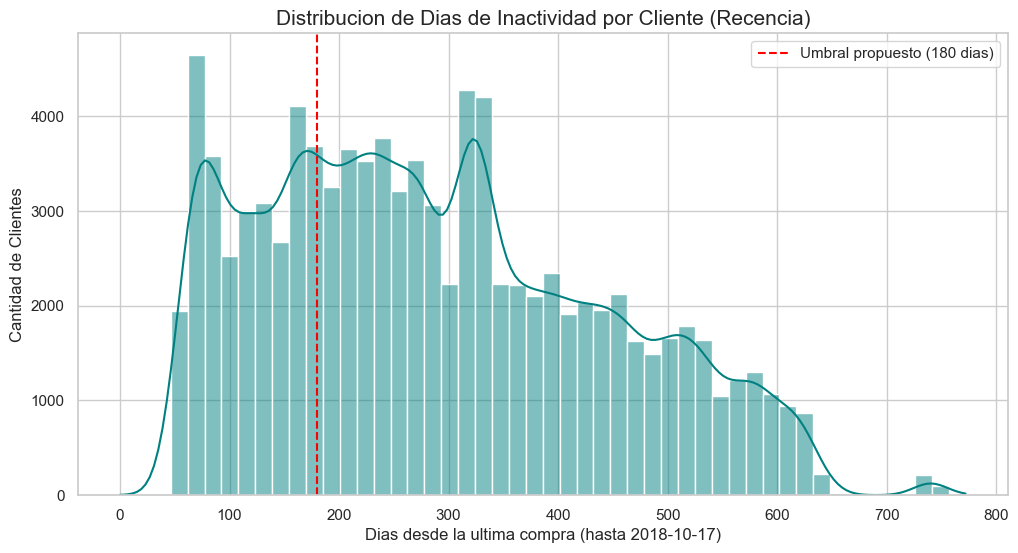

In [39]:
# Crear grafico de histograma para visualizar los datos.

# 1. Configurar el estilo visual
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12,6))

# 2. Crear el histograma
sns.histplot(df_clientes_fecha_ultima_compra['dias_inactividad'], bins=50, kde=True, color='teal')

# 3. Añadir titulos y etiquetas.
plt.title('Distribucion de Dias de Inactividad por Cliente (Recencia)', fontsize=15)
plt.xlabel('Dias desde la ultima compra (hasta 2018-10-17)', fontsize=12)
plt.ylabel('Cantidad de Clientes', fontsize=12)

# 4. Dibujar una linea roja en los 180 dias par visualizar el posible umbral
plt.axvline(180, color='red', linestyle='--', label='Umbral propuesto (180 dias)')
plt.legend()

plt.show()



b) Analisis de Frecuencia de compra: para ver cuantos de estos clientes son compradores recurrentes vs. compradores de una sola vez.

In [43]:
# 1. Calcular la cantidad de pedidos por cada cliente único
frecuencia_pedidos = df_master_clean.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frecuencia_pedidos.columns = ['customer_unique_id', 'total_pedidos']

# 2. Ver la distribución en porcentajes
distribucion_frecuencia = frecuencia_pedidos['total_pedidos'].value_counts(normalize=True).sort_index() * 100

print("Distribución de lealtad de clientes (%):")
print(distribucion_frecuencia.head(5))

Distribución de lealtad de clientes (%):
total_pedidos
1    96.881244
2     2.856518
3     0.211247
4     0.031219
5     0.008325
Name: proportion, dtype: float64
